In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [0]:
dataset = pd.read_csv('Tweets.csv')

In [0]:
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


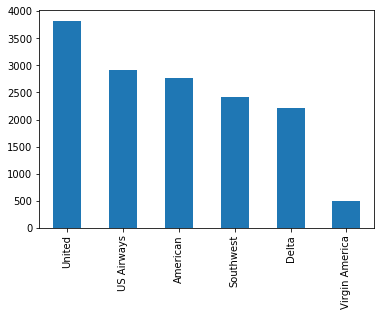

In [0]:
dataset['airline'].value_counts().plot.bar()

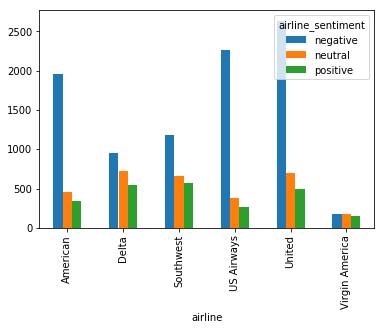

In [0]:
sentiments_X_airlines = pd.crosstab(dataset['airline'], dataset['airline_sentiment'])
sentiments_X_airlines.plot.bar()

In [0]:
X = dataset.iloc[:, 10].values

In [0]:
X[0]

'@VirginAmerica What @dhepburn said.'

In [0]:

def processing(tweets):
  sentiments = []
  for i in range(len(tweets)):
      temp = re.sub('^[a-zA-Z]', ' ', tweets[i])
      temp = re.sub('[^\w\s]', ' ', temp)
      temp = temp.lower()
      temp = temp.split()
      ps = PorterStemmer()
      temp = [ps.stem(word) for word in temp if word not in set(stopwords.words('english'))]
      temp = ' '.join(temp)
      sentiments.append(temp)
      
  return sentiments
    
sentiments = processing(X)

In [0]:
sentiments[0]

'virginamerica dhepburn said'

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 2500, max_df = 0.8, min_df = 5)
X = cv.fit_transform(sentiments).toarray()

In [0]:
labels, unique = pd.factorize(dataset.iloc[:, 1])
y = np.array(labels)

In [0]:
X = X.astype(np.float32)
#y = y.astype(np.float32)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
X_train.shape

(11712, 2440)

In [0]:
y_train.shape

(11712,)

In [0]:
import tensorflow as tf

def model(features, labels, mode):

  layer1 = tf.layers.dense(features, units = 512, activation = tf.nn.relu)
  layer2 = tf.layers.dense(layer1, units = 1024, activation = tf.nn.relu)
  layer3 = tf.layers.dense(layer2, units = 1024, activation = tf.nn.relu)
  
  output = tf.layers.dense(layer3, units = 3)

  probabilities = tf.nn.softmax(logits = output)
  classes = tf.argmax(tf.nn.softmax(logits = output), 1)
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions = classes)

  labels = tf.reshape(labels, [-1])
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = output, 
                                                                       labels = tf.cast(labels, dtype = tf.int64)),
                        name = 'loss_fn')
  
  
  if mode == tf.estimator.ModeKeys.TRAIN:

    optimizer = tf.train.RMSPropOptimizer(0.03)
    train_op = optimizer.minimize(
        loss = loss,
        global_step = tf.train.get_global_step()
    )
    expo = {
        'acc' : tf.metrics.accuracy(labels = labels, predictions = classes, name = 'accuracy_fn')
    }
    
    return tf.estimator.EstimatorSpec(mode = mode, train_op = train_op, loss = loss, export_outputs = expo)
  
  eval_metrics_op = {
      'accuracy' : tf.metrics.accuracy(labels = labels, predictions = classes)
  }
  return tf.estimator.EstimatorSpec(mode = mode, eval_metric_ops = eval_metrics_op, loss = loss)
  


In [0]:
logging_hook = {
    'loss': 'loss_fn',
    
}

tensor_hook = tf.train.LoggingTensorHook(
    tensors = logging_hook, every_n_iter = 100
)

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
classifier = tf.estimator.Estimator(model_fn = model)

I0721 14:23:40.238542 139708533356416 estimator.py:1790] Using default config.
W0721 14:23:40.245610 139708533356416 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpg9mf8_mq
I0721 14:23:40.250251 139708533356416 estimator.py:209] Using config: {'_model_dir': '/tmp/tmpg9mf8_mq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f100be977b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master

In [0]:
train_fn = tf.estimator.inputs.numpy_input_fn(
    x = X_train,
    y = y_train,
    num_epochs = None,
    batch_size = 100,
    shuffle = True,   
)

In [0]:
test_fn = tf.estimator.inputs.numpy_input_fn(
    x = X_test,
    y = y_test,
    num_epochs = 1,
    shuffle = False,
)

In [0]:
classifier.train(
    input_fn = train_fn,
    steps = 1000,
    hooks = [tensor_hook]
)


I0721 14:23:40.337533 139708533356416 estimator.py:1145] Calling model_fn.
I0721 14:23:40.776323 139708533356416 estimator.py:1147] Done calling model_fn.
I0721 14:23:40.781131 139708533356416 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I0721 14:23:40.990510 139708533356416 monitored_session.py:240] Graph was finalized.
I0721 14:23:41.166618 139708533356416 session_manager.py:500] Running local_init_op.
I0721 14:23:41.183883 139708533356416 session_manager.py:502] Done running local_init_op.
I0721 14:23:41.518913 139708533356416 basic_session_run_hooks.py:606] Saving checkpoints for 0 into /tmp/tmpg9mf8_mq/model.ckpt.
I0721 14:23:41.776329 139708533356416 basic_session_run_hooks.py:262] loss = 1.116581
I0721 14:23:41.782530 139708533356416 basic_session_run_hooks.py:262] loss = 1.116581, step = 0
I0721 14:23:42.619043 139708533356416 basic_session_run_hooks.py:692] global_step/sec: 118.569
I0721 14:23:42.625851 139708533356416 basic_session_run_hooks.py:260] loss = 0.87

In [0]:
eval_ = classifier.evaluate(
    input_fn = test_fn,
    steps = 1,
)
print('Accuracy is {}'.format(eval_['accuracy']))

I0721 14:23:50.106303 139708533356416 estimator.py:1145] Calling model_fn.
I0721 14:23:50.272496 139708533356416 estimator.py:1147] Done calling model_fn.
I0721 14:23:50.309152 139708533356416 evaluation.py:255] Starting evaluation at 2019-07-21T14:23:50Z
I0721 14:23:50.426691 139708533356416 monitored_session.py:240] Graph was finalized.
I0721 14:23:50.445319 139708533356416 saver.py:1280] Restoring parameters from /tmp/tmpg9mf8_mq/model.ckpt-1000
I0721 14:23:50.530583 139708533356416 session_manager.py:500] Running local_init_op.
I0721 14:23:50.561573 139708533356416 session_manager.py:502] Done running local_init_op.
I0721 14:23:50.653817 139708533356416 evaluation.py:167] Evaluation [1/1]
I0721 14:23:50.688229 139708533356416 evaluation.py:275] Finished evaluation at 2019-07-21-14:23:50
I0721 14:23:50.690281 139708533356416 estimator.py:2039] Saving dict for global step 1000: accuracy = 0.78125, global_step = 1000, loss = 2.995279
I0721 14:23:50.763777 139708533356416 estimator.py:

Accuracy is 0.78125
